# **Import Required packages**

In [ ]:
#install transformers package
!pip install transformers==4.16.2
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 56.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.8 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=f71f4bcd6f49c7e903ecd3a309a2124caf48036a04504b2b2ed9c60209b1215b
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully built sacremoses
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.4 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Mon Oct 23 12:56:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#import required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)
import re
import torch #1.9.1
from tqdm.notebook import tqdm
from transformers import BertTokenizer, BertForSequenceClassification,DistilBertTokenizer,DistilBertForSequenceClassification,RobertaTokenizer,RobertaForSequenceClassification
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np
from sklearn.metrics import f1_score,classification_report, confusion_matrix

# **Import Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#post data
df = pd.read_csv('/content/drive/MyDrive/free lance/post classification transformers/labled_data.csv',usecols=['post','compulsion','obs-com','obsession'])
df.head()

,post,compulsion,obs-com,obsession
0,Hi -\nSo I haven't been on here since December...,0,0,1
1,"Hi all, hope you're all having a wonderful ban...",1,1,1
2,"Hi, \nFirst, I hope everyone managed to have s...",0,0,1
3,Hello everyone. I could really use your help r...,0,0,1
4,"Though it comes in many flavors, one of the mo...",1,1,1


# **Data Preparation**

In [ ]:
#split data to train and test ensembles
#80% of the data for the training & 20% of data from the testing
data_train,data_test = train_test_split(df,test_size=0.2,random_state=42)

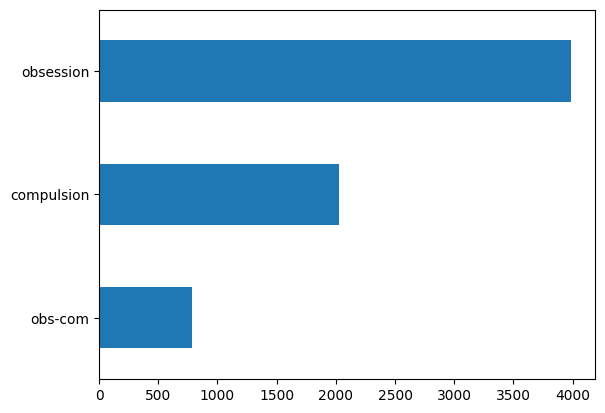

In [ ]:
#print the number of post in each ensemble for each class(train data)
LABEL_COLUMNS = data_train.columns.tolist()[1:]
data_train[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

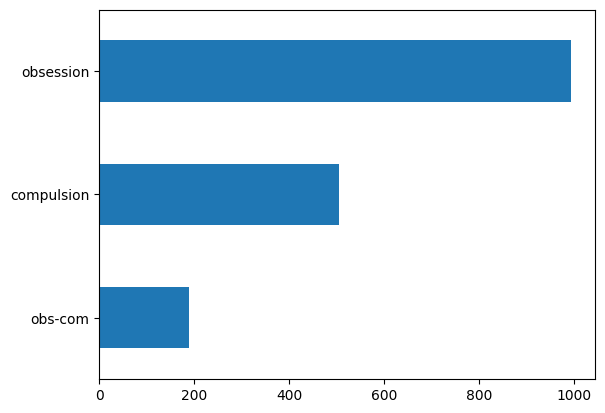

In [ ]:
#print the number of post in each ensemble for each class(train data)
LABEL_COLUMNS = data_test.columns.tolist()[1:]
data_test[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

In [ ]:
import re
#define the process of text cleaning
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r' ',text)
#Clean Text
def clean_text(data):
  # convert catacter to lowercase
  data['clean_text']=data['post'].str.lower()
  #remove URLS
  data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r"http\S+", "", elem))
  #remove ponctuation
  data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r"[^\w\s]", "", elem))
  #remove
  data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r'/n',"",elem))
  #remove degits
  data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r'\d+',"",elem))
  #remove emojis
  data['clean_text'] = data['clean_text'].apply(lambda elem:deEmojify(elem))
  #remove multiple spaces
  data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r'\s+'," ",elem))
  #remove single caracter
  data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r'\s+[a-zA-Z]\s+'," ",elem))

  return data

In [ ]:
#apply the process of cleaning for the train and test data
data_train = clean_text(data_train)
data_test = clean_text(data_test)

# **Tokenization (BERT)**

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
#define the maximum length for all the sequences
Max_len = 500


class GPReviewDataset(Dataset):

    def __init__(self, posts, targets, tokenizer, max_len):
        self.posts = posts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.posts)

    def __getitem__(self, item):
        post = str(self.posts[item])
        target = self.targets[item]
        #for sent in sentences`encode_plus` will:
           #(1) Tokenize the sentence.
           #(2) Prepend the `[CLS]` token to the start.
           #(3) Append the `[SEP]` token to the end.
           #(4) Map tokens to their IDs.
           #(5) Pad or truncate the sentence to `max_length`
           #(6) Create attention masks for [PAD] tokens
        encoding = self.tokenizer.encode_plus(
          post,
          add_special_tokens=True, #add special tokens [CLS] in the beginning of the sequence , [SEP] in the end
          max_length=self.max_len, #define the maximum length for all the sequences
          return_token_type_ids=False, #we don't need to return token_type_ids because each text is traited as single sequence
          pad_to_max_length=True, #if a length of sequence is less of the maximum length so we need to add [PAD] tokens
          return_attention_mask=True, #return attention musk vector to give the model the ability to differentiate between what is real token and what is padding token
          return_tensors='pt', #return the result as pytorch tensor
    )

        return {
          'post_text': post,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
"""
One thing to note is that we need to reload IterableDataset once the loop reaches the end.
So, if you do the for loop again, you will get an StopIteration exception.
We can use DataLoader to generate sentence batches
"""
def create_data_loader(df, tokenizer, max_len,batch_size):

    ds = GPReviewDataset(
    posts=df.post.to_numpy(),
    targets=df[['compulsion','obs-com','obsession']].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
      )
    return DataLoader(
    ds,
    batch_size=batch_size
  )

In [ ]:
#define the batch_size for the dataloader
BATCH_SIZE = 16
#create a dataloader for the train & test data
train_data_loader = create_data_loader(data_train, tokenizer, Max_len,BATCH_SIZE)
val_data_loader = create_data_loader(data_test, tokenizer, Max_len,BATCH_SIZE)

# **Tokenization (RoBERTa)**

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base',do_lower_case=True)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
#define the maximum length for all the sequences
Max_len = 500


class GPReviewDataset(Dataset):

    def __init__(self, posts, targets, tokenizer, max_len):
        self.posts = posts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.posts)

    def __getitem__(self, item):
        post = str(self.posts[item])
        target = self.targets[item]
        #for sent in sentences`encode_plus` will:
           #(1) Tokenize the sentence.
           #(2) Prepend the `[CLS]` token to the start.
           #(3) Append the `[SEP]` token to the end.
           #(4) Map tokens to their IDs.
           #(5) Pad or truncate the sentence to `max_length`
           #(6) Create attention masks for [PAD] tokens
        encoding = self.tokenizer.encode_plus(
          post,
          add_special_tokens=True, #add special tokens [CLS] in the beginning of the sequence , [SEP] in the end
          max_length=self.max_len, #define the maximum length for all the sequences
          return_token_type_ids=False, #we don't need to return token_type_ids because each text is traited as single sequence
          pad_to_max_length=True, #if a length of sequence is less of the maximum length so we need to add [PAD] tokens
          return_attention_mask=True, #return attention musk vector to give the model the ability to differentiate between what is real token and what is padding token
          return_tensors='pt', #return the result as pytorch tensor
    )

        return {
          'post_text': post,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
"""
One thing to note is that we need to reload IterableDataset once the loop reaches the end.
So, if you do the for loop again, you will get an StopIteration exception.
We can use DataLoader to generate sentence batches
"""
def create_data_loader(df, tokenizer, max_len,batch_size):

    ds = GPReviewDataset(
    posts=df.post.to_numpy(),
    targets=df[['compulsion','obs-com','obsession']].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
      )
    return DataLoader(
    ds,
    batch_size=batch_size
  )

In [ ]:
#define the batch_size for the dataloader
BATCH_SIZE = 16
#create a dataloader for the train & test data
train_data_loader = create_data_loader(data_train, tokenizer, Max_len,BATCH_SIZE)
val_data_loader = create_data_loader(data_test, tokenizer, Max_len,BATCH_SIZE)

# **Model training (bert)**

In [ ]:
#define the pre trained models
PRE_TRAINED_MODEL_NAME_BERT = 'bert-base-uncased'
LABEL_NUMBERS = 3

model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME_BERT,
                                                            num_labels = LABEL_NUMBERS, #number of classes
                                                            output_attentions = False,
                                                            output_hidden_states = False)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
#Tell pytorch to run this model on the GPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#pass the model to the GPU
model=model.to(device)

cuda


In [ ]:
#number od epcohs
EPOCHS = 4
#define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)
#define the total steps
total_steps = len(train_data_loader) * EPOCHS
#define the scheduler for schedule the learning rate
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.BCEWithLogitsLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.metrics import f1_score

def calculate_f1_score(targets, preds, average='micro'):
    """
    Calculate the F1 score for multi-label classification.

    Parameters:
    - targets: Tensor of true labels (ground truth)
    - preds: Tensor of predicted labels
    - threshold: The threshold for converting probabilities to binary labels
    - average: Type of F1 score to calculate ('micro', 'macro', 'weighted', or 'samples')

    Returns:
    - F1 score
    """

    # Calculate the F1 score
    f1 = f1_score(targets.cpu().numpy(), preds.cpu().numpy(), average=average)

    return f1

In [ ]:
"""
Below is our training loop,fundamentally for each pass in our loop we have a trianing phase and a validation phase. At each pass we need to:
* Unpack our data inputs and labels
* Load data onto the GPU for acceleration
* Clear out the gradients calculated in the previous pass.
* In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
* Forward pass (feed input data through the network)
* Backward pass (backpropagation)
* Tell the network to update parameters with optimizer.step()
* Track variables for monitoring progress
"""
def train_epoch(model, data_loader,optimizer, device, scheduler, n_examples,loss_fn,calculate_f1_score):
    # Put the model into training mode.
    # `train` just changes the *mode*, it doesn't *perform* the training.
    #dropout` and `batchnorm` layers behave differently during training vs testing
    model = model.train()

    losses = [] #list contain the losses for all the iterations
    acc = [] #list contain the f1 score for all the iterations

    # For each batch of training data...
    for d in data_loader:
        #Unpack this training batch from our dataloader and copy each tensor to the GPU using (.to)
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        #Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()

        #Forward pass (feed input data through the network)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        logits = outputs.logits

        # Apply a sigmoid activation to 'outputs' for multi-label classification
        outputs = torch.sigmoid(logits)

        # Round the output to 0 or 1 based on a threshold (e.g., 0.5)
        preds = (outputs > 0.5).float()

        # Calculate the F1 score
        f1 = calculate_f1_score(targets.float(), preds)
        acc.append(f1)

        # Calculate the loss using BCE loss
        loss = loss_fn(logits, targets.float())

        #add the loss in the list of losses
        losses.append(loss.item())

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.This is to help prevent the "exploding gradients" problem.
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        #Always clear any previously calculated gradients before performing a backward pass.
        optimizer.zero_grad()

    #return the average loss and F1 score over the training data.
    return  np.mean(losses),np.mean(acc)

In [ ]:
"""
Evalution loop:
* Unpack our data inputs and labels
* Load data onto the GPU for acceleration
* Forward pass (feed input data through the network)
* Compute loss on our validation data and track variables for monitoring progress
"""
def eval_model(model, data_loader, device, n_examples,loss_fn,calculate_f1_score ):
    ## Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model = model.eval()

    losses = [] #list contain the losses for all the iterations
    acc = [] #list contain the f1 score for all the iterations

    #Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
         # For each batch of validation data...
        for d in data_loader:
            #Unpack the inputs from our dataloader and copy each tensor to the GPU using (.to)
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask)
            logits = outputs.logits

            # Apply a sigmoid activation to 'outputs' for multi-label classification
            outputs = torch.sigmoid(logits)

            # Round the output to 0 or 1 based on a threshold (e.g., 0.5)
            preds = (outputs > 0.5).float()

            # Calculate the loss using BCE loss
            loss = loss_fn(logits , targets.float())

            # Calculate the F1 score
            f1 = calculate_f1_score(targets.float(), preds)
            acc.append(f1)

            #add the loss in the list of losses
            losses.append(loss.item())

    #return the average loss and F1 score over the validation data.
    return  np.mean(losses),np.mean(acc)

In [ ]:
%%time
from collections import defaultdict
history = defaultdict(list)
for epoch in tqdm(range(EPOCHS)):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    #trainning
    train_loss,train_acc = train_epoch(

        model,
        train_data_loader,
        optimizer,
        device,
        scheduler,
        len(data_train),
        loss_fn,
        calculate_f1_score
        )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    #validation
    val_loss,val_acc= eval_model(
        model,
        val_data_loader,
        device,
        len(data_test),
        loss_fn,
        calculate_f1_score
        )
    #save score and loss for train & test
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    #save model for each epoch
    torch.save(model.state_dict(), f'./finetuned_{PRE_TRAINED_MODEL_NAME_BERT}_epoch{epoch}.model')

  0%|          | 0/4 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch 1/4
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.28573615465983293 accuracy 0.8535952322865228


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.08638302806946563 accuracy 0.9766381885278743
Epoch 2/4
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.08636037638785726 accuracy 0.9697779105984589


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.06058079382495546 accuracy 0.9794798949962688
Epoch 3/4
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.0651079376651224 accuracy 0.9765940437796323


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.06415969109526132 accuracy 0.981493130302804
Epoch 4/4
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.04632862516900343 accuracy 0.9850996459598852


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.059416832913440173 accuracy 0.984601096644815
CPU times: user 37min 18s, sys: 8.81 s, total: 37min 26s
Wall time: 38min 10s


# **Model training (RoBERTa)**

In [ ]:
#define the pre trained models
PRE_TRAINED_MODEL_NAME_ROBERTA = 'roberta-base'
LABEL_NUMBERS = 3

model = RobertaForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME_ROBERTA,
                                                            num_labels = LABEL_NUMBERS, #number of classes
                                                            output_attentions = False,
                                                            output_hidden_states = False)

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [ ]:
#Tell pytorch to run this model on the GPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#pass the model to the GPU
model=model.to(device)

cuda


In [ ]:
#number od epcohs
EPOCHS = 4
#define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)
#define the total steps
total_steps = len(train_data_loader) * EPOCHS
#define the scheduler for schedule the learning rate
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.BCEWithLogitsLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.metrics import f1_score

def calculate_f1_score(targets, preds, average='micro'):
    """
    Calculate the F1 score for multi-label classification.

    Parameters:
    - targets: Tensor of true labels (ground truth)
    - preds: Tensor of predicted labels
    - threshold: The threshold for converting probabilities to binary labels
    - average: Type of F1 score to calculate ('micro', 'macro', 'weighted', or 'samples')

    Returns:
    - F1 score
    """

    # Calculate the F1 score
    f1 = f1_score(targets.cpu().numpy(), preds.cpu().numpy(), average=average)

    return f1

In [ ]:
"""
Below is our training loop,fundamentally for each pass in our loop we have a trianing phase and a validation phase. At each pass we need to:
* Unpack our data inputs and labels
* Load data onto the GPU for acceleration
* Clear out the gradients calculated in the previous pass.
* In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
* Forward pass (feed input data through the network)
* Backward pass (backpropagation)
* Tell the network to update parameters with optimizer.step()
* Track variables for monitoring progress
"""
def train_epoch(model, data_loader,optimizer, device, scheduler, n_examples,loss_fn,calculate_f1_score):
    # Put the model into training mode.
    # `train` just changes the *mode*, it doesn't *perform* the training.
    #dropout` and `batchnorm` layers behave differently during training vs testing
    model = model.train()

    losses = [] #list contain the losses for all the iterations
    acc = [] #list contain the f1 score for all the iterations

    # For each batch of training data...
    for d in data_loader:
        #Unpack this training batch from our dataloader and copy each tensor to the GPU using (.to)
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        #Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()

        #Forward pass (feed input data through the network)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        logits = outputs.logits

        # Apply a sigmoid activation to 'outputs' for multi-label classification
        outputs = torch.sigmoid(logits)

        # Round the output to 0 or 1 based on a threshold (e.g., 0.5)
        preds = (outputs > 0.5).float()

        # Calculate the F1 score
        f1 = calculate_f1_score(targets.float(), preds)
        acc.append(f1)

        # Calculate the loss using BCE loss
        loss = loss_fn(logits, targets.float())

        #add the loss in the list of losses
        losses.append(loss.item())

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.This is to help prevent the "exploding gradients" problem.
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        #Always clear any previously calculated gradients before performing a backward pass.
        optimizer.zero_grad()

    #return the average loss and F1 score over the training data.
    return  np.mean(losses),np.mean(acc)

In [ ]:
"""
Evalution loop:
* Unpack our data inputs and labels
* Load data onto the GPU for acceleration
* Forward pass (feed input data through the network)
* Compute loss on our validation data and track variables for monitoring progress
"""
def eval_model(model, data_loader, device, n_examples,loss_fn,calculate_f1_score ):
    ## Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model = model.eval()

    losses = [] #list contain the losses for all the iterations
    acc = [] #list contain the f1 score for all the iterations

    #Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
         # For each batch of validation data...
        for d in data_loader:
            #Unpack the inputs from our dataloader and copy each tensor to the GPU using (.to)
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask)
            logits = outputs.logits

            # Apply a sigmoid activation to 'outputs' for multi-label classification
            outputs = torch.sigmoid(logits)

            # Round the output to 0 or 1 based on a threshold (e.g., 0.5)
            preds = (outputs > 0.5).float()

            # Calculate the loss using BCE loss
            loss = loss_fn(logits , targets.float())

            # Calculate the F1 score
            f1 = calculate_f1_score(targets.float(), preds)
            acc.append(f1)

            #add the loss in the list of losses
            losses.append(loss.item())

    #return the average loss and F1 score over the validation data.
    return  np.mean(losses),np.mean(acc)

In [ ]:
%%time
from collections import defaultdict
history = defaultdict(list)
for epoch in tqdm(range(EPOCHS)):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    #trainning
    train_loss,train_acc = train_epoch(

        model,
        train_data_loader,
        optimizer,
        device,
        scheduler,
        len(data_train),
        loss_fn,
        calculate_f1_score
        )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    #validation
    val_loss,val_acc= eval_model(
        model,
        val_data_loader,
        device,
        len(data_test),
        loss_fn,
        calculate_f1_score
        )
    #save score and loss for train & test
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    #save model for each epoch
    torch.save(model.state_dict(), f'./finetuned_{PRE_TRAINED_MODEL_NAME_ROBERTA}_epoch{epoch}.model')

  0%|          | 0/4 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch 1/4
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.2708535842972285 accuracy 0.8471453443053067


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.06380293135553962 accuracy 0.9827910551612544
Epoch 2/4
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.07435097850052776 accuracy 0.9766444478772148


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.05209176524019823 accuracy 0.9847639188339281
Epoch 3/4
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.061139946787833896 accuracy 0.9825264115742667


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.05206801986503529 accuracy 0.9857155246817334
Epoch 4/4
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Train loss 0.05087352877556596 accuracy 0.9857881247545617


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.051050712933718434 accuracy 0.9871907646282804
CPU times: user 34min 53s, sys: 11.6 s, total: 35min 5s
Wall time: 35min 27s


# **Evaluate the model(BERT)**

<ipython-input-22-dc383e883fe9>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


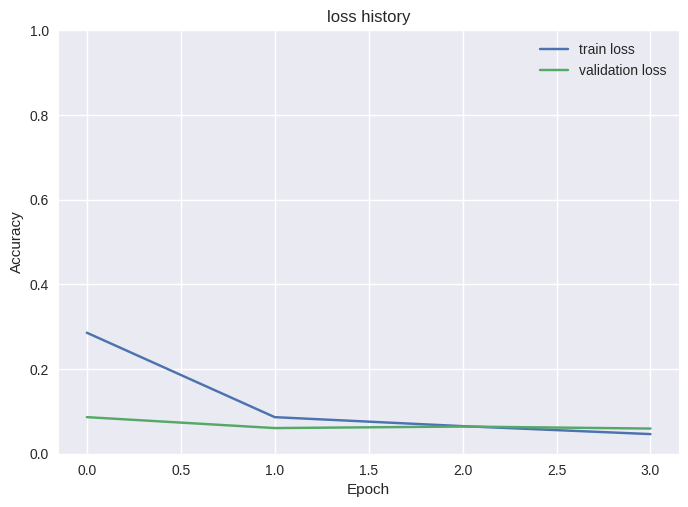

In [ ]:
#plot the loss evolution between le train and the test
plt.style.use('seaborn')
plt.plot([i for i in history['train_loss']], label='train loss')
plt.plot([i for i in history['val_loss']], label='validation loss')

plt.title('loss history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

<ipython-input-23-4a2a24164313>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


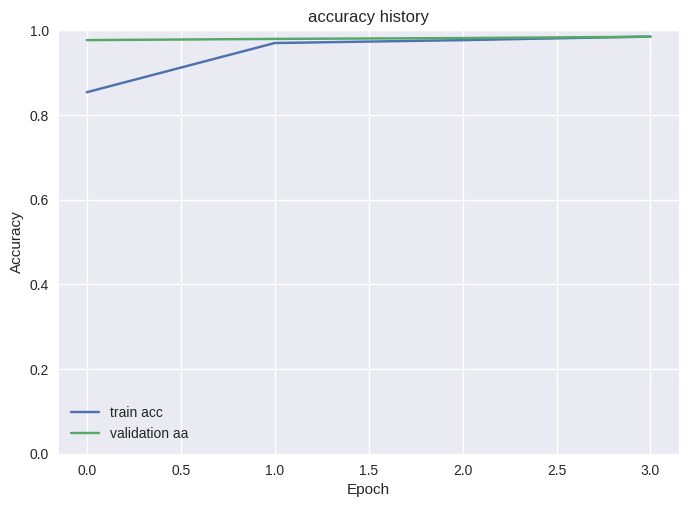

In [ ]:
#plot the accuracy (F1) evolution between le train and the test
plt.style.use('seaborn')
plt.plot([i for i in history['train_acc']], label='train acc')
plt.plot([i for i in history['val_acc']], label='validation aa')

plt.title('accuracy history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# Create a list of dictionaries for the results
results = []
epoch = 1
for f, b, train_acc, val_acc in zip(history['train_loss'], history['val_loss'], history['train_acc'], history['val_acc']):
    result = {
        'epoch' : f'epoch {epoch}',
        'Train Loss': f,
        'Validation Loss': b,
        'Train Accuracy': train_acc,
        'Validation Accuracy': val_acc
    }
    results.append(result)
    epoch+=1

# Convert the list of dictionaries to a Pandas DataFrame
df = pd.DataFrame(results)

# Print the DataFrame
df

,epoch,Train Loss,Validation Loss,Train Accuracy,Validation Accuracy
0,epoch 1,0.285736,0.086383,0.853595,0.976638
1,epoch 2,0.086360,0.060581,0.969778,0.979480
2,epoch 3,0.065108,0.064160,0.976594,0.981493
3,epoch 4,0.046329,0.059417,0.985100,0.984601


In [ ]:
#load the best epoch (have the less loss and the loss for the train and test arealmost equal) to our model
model.load_state_dict(torch.load('/content/finetuned_bert-base-uncased_epoch3.model'))

<All keys matched successfully>

In [ ]:
#define function that predict all the data in the prediction dataloader to evaluate our model after the training
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                  )
            logits = outputs.logits

            # Apply a sigmoid activation to 'outputs' for multi-label classification
            outputs = torch.sigmoid(logits)
            # Round the output to 0 or 1 based on a threshold (e.g., 0.5)
            preds = (outputs > 0.5).float()

            predictions.extend(preds.cpu().data.numpy())
            real_values.extend(targets)

        real_values = torch.stack(real_values).cpu()
        return predictions, real_values

In [ ]:
 y_pred, y_test = get_predictions(
  model,
  val_data_loader
)

In [ ]:
#classification report
print(classification_report(y_test, y_pred,target_names=['compulsion','obs-com','obsession']))

              precision    recall  f1-score   support

  compulsion       0.99      0.98      0.99       505
     obs-com       0.95      0.93      0.94       190
   obsession       0.99      0.99      0.99       994

   micro avg       0.99      0.98      0.98      1689
   macro avg       0.98      0.97      0.97      1689
weighted avg       0.99      0.98      0.98      1689
 samples avg       0.99      0.99      0.99      1689



In [ ]:
#save the model and the tokenizer in the driveto use it later for the prediction
model.save_pretrained('/content/drive/MyDrive/free lance/post classification transformers/models/bertModel')
tokenizer.save_pretrained('/content/drive/MyDrive/free lance/post classification transformers/tokenizers/bertTokenizer')

('/content/drive/MyDrive/free lance/post classification transformers/tokenizers/bertTokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/free lance/post classification transformers/tokenizers/bertTokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/free lance/post classification transformers/tokenizers/bertTokenizer/vocab.txt',
 '/content/drive/MyDrive/free lance/post classification transformers/tokenizers/bertTokenizer/added_tokens.json')

# **Evaluate the model(ROBERTA)**

<ipython-input-22-dc383e883fe9>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


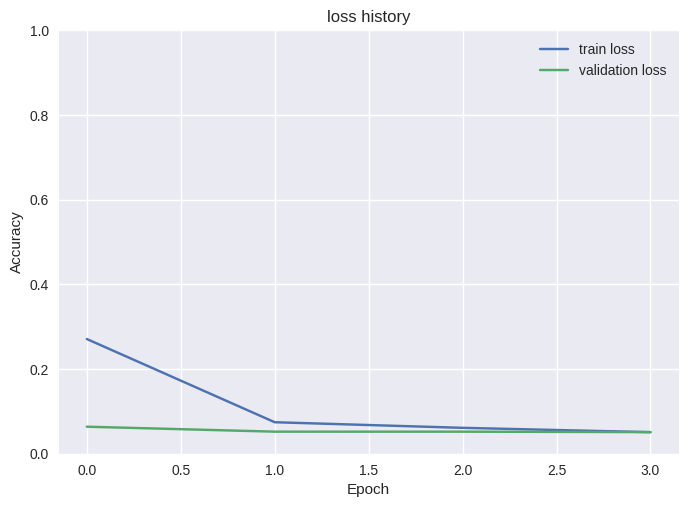

In [ ]:
#plot the loss evolution between le train and the test
plt.style.use('seaborn')
plt.plot([i for i in history['train_loss']], label='train loss')
plt.plot([i for i in history['val_loss']], label='validation loss')

plt.title('loss history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

<ipython-input-23-4a2a24164313>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


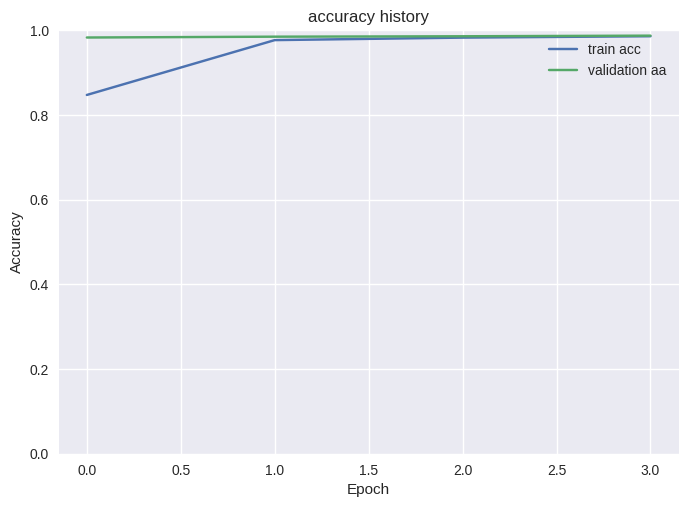

In [ ]:
#plot the accuracy (F1) evolution between le train and the test
plt.style.use('seaborn')
plt.plot([i for i in history['train_acc']], label='train acc')
plt.plot([i for i in history['val_acc']], label='validation aa')

plt.title('accuracy history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# Create a list of dictionaries for the results
results = []
epoch = 1
for f, b, train_acc, val_acc in zip(history['train_loss'], history['val_loss'], history['train_acc'], history['val_acc']):
    result = {
        'epoch' : f'epoch {epoch}',
        'Train Loss': f,
        'Validation Loss': b,
        'Train Accuracy': train_acc,
        'Validation Accuracy': val_acc
    }
    results.append(result)
    epoch+=1

# Convert the list of dictionaries to a Pandas DataFrame
df = pd.DataFrame(results)

# Print the DataFrame
df

,epoch,Train Loss,Validation Loss,Train Accuracy,Validation Accuracy
0,epoch 1,0.270854,0.063803,0.847145,0.982791
1,epoch 2,0.074351,0.052092,0.976644,0.984764
2,epoch 3,0.061140,0.052068,0.982526,0.985716
3,epoch 4,0.050874,0.051051,0.985788,0.987191


In [ ]:
#load the best epoch (have the less loss and the loss for the train and test arealmost equal) to our model
model.load_state_dict(torch.load('/content/finetuned_roberta-base_epoch3.model'))

<All keys matched successfully>

In [ ]:
#define function that predict all the data in the prediction dataloader to evaluate our model after the training
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                  )
            logits = outputs.logits

            # Apply a sigmoid activation to 'outputs' for multi-label classification
            outputs = torch.sigmoid(logits)
            # Round the output to 0 or 1 based on a threshold (e.g., 0.5)
            preds = (outputs > 0.5).float()

            predictions.extend(preds.cpu().data.numpy())
            real_values.extend(targets)

        real_values = torch.stack(real_values).cpu()
        return predictions, real_values

In [ ]:
 y_pred, y_test = get_predictions(
  model,
  val_data_loader
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
#classification report
print(classification_report(y_test, y_pred,target_names=['compulsion','obs-com','obsession']))

              precision    recall  f1-score   support

  compulsion       1.00      0.97      0.98       505
     obs-com       0.99      0.92      0.95       190
   obsession       0.99      0.99      0.99       994

   micro avg       0.99      0.98      0.99      1689
   macro avg       0.99      0.96      0.98      1689
weighted avg       0.99      0.98      0.99      1689
 samples avg       0.99      0.99      0.99      1689



In [ ]:
#save the model and the tokenizer in the driveto use it later for the prediction
model.save_pretrained('/content/drive/MyDrive/free lance/post classification transformers/models/RobertaModel')
tokenizer.save_pretrained('/content/drive/MyDrive/free lance/post classification transformers/tokenizers/RobertaTokenizer')

('/content/drive/MyDrive/free lance/post classification transformers/tokenizers/RobertaTokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/free lance/post classification transformers/tokenizers/RobertaTokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/free lance/post classification transformers/tokenizers/RobertaTokenizer/vocab.json',
 '/content/drive/MyDrive/free lance/post classification transformers/tokenizers/RobertaTokenizer/merges.txt',
 '/content/drive/MyDrive/free lance/post classification transformers/tokenizers/RobertaTokenizer/added_tokens.json')

# **Make Prediction**

In [ ]:
#load pre trained model and tokenizer (bert)
from transformers import BertForSequenceClassification,BertTokenizer
model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/free lance/post classification transformers/models/bertModel')
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/free lance/post classification transformers/tokenizers/bertTokenizer')

In [ ]:
#load pre trained model and tokenizer (roberta)
from transformers import RobertaForSequenceClassification,RobertaTokenizer
model = RobertaForSequenceClassification.from_pretrained('/content/drive/MyDrive/free lance/post classification transformers/models/RobertaModel')
tokenizer = RobertaTokenizer.from_pretrained('/content/drive/MyDrive/free lance/post classification transformers/tokenizers/RobertaTokenizer')

In [ ]:
import torch
#Tell pytorch to run this model on the GPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#pass the model to the GPU
model=model.to(device)

cuda


In [ ]:
#define a process for predict some explample that :

#apply text cleaning
#tokenize the text using the pre trained model asscociated to the optimal model choiced
#pass the data to the model to make prediction

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r' ',text)
#Clean Text
def clean_text(text):
  # convert catacter to lowercase
  text = text.lower()
  #remove URLS
  text = re.sub(r"http\S+", "",text)
  #remove ponctuation
  text = re.sub(r"[^\w\s]", "",text)
  #remove
  text = re.sub('/n',"",text)
  #remove degits
  text = re.sub(r'\d+',"",text)
  #remove emojis
  text = deEmojify(text)
  #remove multiple spaces
  text = re.sub(r'\s+','',text)
  #remove single caracter
  text = re.sub(r'\s+[a-zA-Z]\s+'," ",text)
  return text
def predict(text,model):
    encoded_review = tokenizer.encode_plus(
    clean_text(text),
          max_length=500,
          add_special_tokens=True,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
          )
    model=model.eval()
    ids = encoded_review['input_ids'].to(device)
    mask = encoded_review['attention_mask'].to(device)
    outputs = model(
            input_ids=ids,
            attention_mask=mask
          )
    logits = outputs.logits

    # Apply a sigmoid activation to 'outputs' for multi-label classification
    outputs = torch.sigmoid(logits)
    # Round the output to 0 or 1 based on a threshold (e.g., 0.5)
    preds = (outputs > 0.5).float()
    pred = preds.detach().cpu().numpy().tolist()[0]
    return pred


In [ ]:
#read unlabled data file as pandas dataframe
df_pred = pd.read_csv('/content/drive/MyDrive/free lance/post classification transformers/unlabled_data.csv')
df_pred['prediction'] = df_pred['post'].apply(lambda x:predict(x,model))
df_pred['compulsion'] = df_pred['prediction'].apply(lambda x:x[0])
df_pred['obs-com'] = df_pred['prediction'].apply(lambda x:x[1])
df_pred['obsession'] = df_pred['prediction'].apply(lambda x:x[2])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
df_pred.drop('prediction',axis=1,inplace=True)

In [ ]:
model_name = 'bert'
#model_name = 'roberta'
# model_name = ''
df_pred.to_csv(f'/content/drive/MyDrive/free lance/post classification transformers/prediction/{model_name}_model_prediction.csv',index=False)